In [1]:
# For user-defined post processing and plotting functions
import sys
sys.path.insert(0, "../..")
from utils.plot_utils_v2 import *

Welcome to the "how to" of Markov Chain Monte Carlo using PYMC. A python software package allowing you to fit complex models with ease. 

## Case Study 2: Logistic Growth

We are going to establish a logistic model in this case study. The ODE and it's solution will be defined in the near future.  

First things first. Data! Pandas is the defacto python package for reading in data. It's also smart to handle any necessary data conversions during this step. You may not need to and that's just fine! It all depends on what you are looking for.

In [2]:
## Cell 1 ##

import pandas as pd

# import alive
dataset = pd.read_csv("../../case_study_2/python/data/total_cells.csv")
cells = dataset.tail(15)
cells_time = cells['Time (days)'].values
cells_density = 1e6*cells[' Density (1e6/ml)'].values

Here is the first thing that needs to be done. We will setup the logistic ODE that will adapt to the data. To do this, you will use variables that PyMC gives you by 'default'. Let me explain. Note that in Cell 2 there are 3 parameters being passed in (y, t, params). You will also not see these variables being explicitly passed in this way anywhere. Here is what happens. When you create the ODE function in Cell 2, it gets passed to the the 'cell_model' in Cell 3. Now look to where the 'cell_model' is called in cell 4. There it passes priors into Y0 and theta. The connection is Y0 goes to y, and theta goes to params. The order you hand over the priors matters so call them in the correct order when creating the ODE equation. Be sure to keep this in mind and take note of the position of you priors when you pass them, and the indicies used in y and params to setup your variables and inital conditions!

**P**: Initial Value  
**r**: Growith Rate  
**K**: Carrying Capacity

$$
\frac{dP}{dt} = r \left(1 - \frac{P}{K}\right) P
$$

In [3]:
## Cell 2 ##

def logistic_growth(y, t, params):
    P = y[0]
    
    r = params[0]
    K = params[1]
    
    return r * (1 - P / K) * P 

Here is the model we spoke about earlier. Here is what goes into each variable.

**func**: the ODE function you just created  
**times**: the time steps from your data  
**n_states**: possible states count  
**n_theta**: Unique parameter count  
**t0**: inital time step (should almost always be 0)

In [4]:
## Cell 3 ##

import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=logistic_growth,
    times=cells_time,
    n_states=1,
    n_theta=2,
    t0=0
)

c:\Users\Whisk\anaconda3\envs\MCMC_Modeling\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


Here is where we assign our priors. Choosing priors is an interesting combination of art and science. You have all kinds of options. Uniform, normal, lognormal, halfnormal. It all depends on what you need. With these uniform priors we are essentially saying. We believe the proper value for the model will be equally likely within this range and WILL NOT be outside this range. Your half normal distribution is a PDF that is only posotive and extends to infinity. This is usually used for your error or standard deviation. This is saying we know we can not have negative error, and we believe the error will be closer to 0 than farther away, however, we are not explicitly capping it off in the positive direction. Below are the priors visualized. 

<img src="../prior_figures/priors_c2p1.png" width="300"/>

Next is getting the current ODE results. We spoke about how to pass the priors in previously. Be careful during this step!

The final function is the Likelihood of the model. This is where we see how well the model results estimatied the data.

We name the random variable 'y_total'.

For mu, this is a bit complicated so we'll break this down.  
- y_hat[:,0] pulls the predicited trajectory for live cells from the ODE solution, note it's position in y_hat matches it's priors position when passed to cell_model.  
- pm.math.clip() prevents taking log(0) by setting a minimum positive value to near 0.  
- pm.math.log() puts predictions on a log scale which matches the log transformed observed data. 

Sigma: The prior you just created for it! Simple.  
Observered: The true cell data you read in earlier.

In [5]:
## Cell 4 ##

import numpy as np
with pm.Model() as model:
    r = pm.Uniform(r"$r$ (growth rate)", lower=0.5, upper=1)
    K = pm.Uniform(r"$K$ (carrying capacity)" , lower=1e6, upper=4e7)
    P0 = pm.Uniform(r"$P_0$ (init. live)", lower=1e5, upper=3e5)
    sigma_live = pm.HalfNormal(r"$\sigma_L$", 3)

    y_hat = cell_model(y0=[P0], theta=[r,K])
    
    pm.Normal("Y_total", 
              mu=pm.math.log(pm.math.clip(y_hat[:, 0], 1e-8, np.inf)),
              sigma=sigma_live,
              observed =  np.log(cells_density))


When you are finally ready to run the model you will do so in the form shown between the '''. Here are what the variables being passed into pm.sample mean.

**draws**: poterior values to be generated.  
**tune**: Some under the hood PyMC magic that 'warms it up'. Keep this between 500 and 2000 depending on how complex your model is.  
**chains / cores**: Amount of chains you want to compute in parallel. Keep these values the same for most basic usage.  
**return_inferencedata**: returns an ARVIZ inferencedata object which we'll use for easy reading of our output.
**target_accept**: the % of times you accept the improved likelihood at each step of the chain. This is your exploration vs exploitation balance.

To save time, we are just going to read in the pre-computed **trace** and print so you can see the output. We will use ARVIZ and Matplotlib to do so. 

In [6]:
## Cell 5 ##

'''
with model:
    trace = pm.sample(draws=2000, tune=500, chains=3, return_inferencedata=True, target_accept=0.95, cores = 3) 
'''
import arviz as az
import matplotlib.pyplot as plt

trace = az.from_netcdf("chains/case_study_2_p1_trace.nc")

To interpret the output we have some user-defined postprocessing and plotting functions. They are in our GitHub repo.

Sampling: [$K$ (carrying capacity), $P_0$ (init. live), $\sigma_L$, $r$ (growth rate), Y_total]


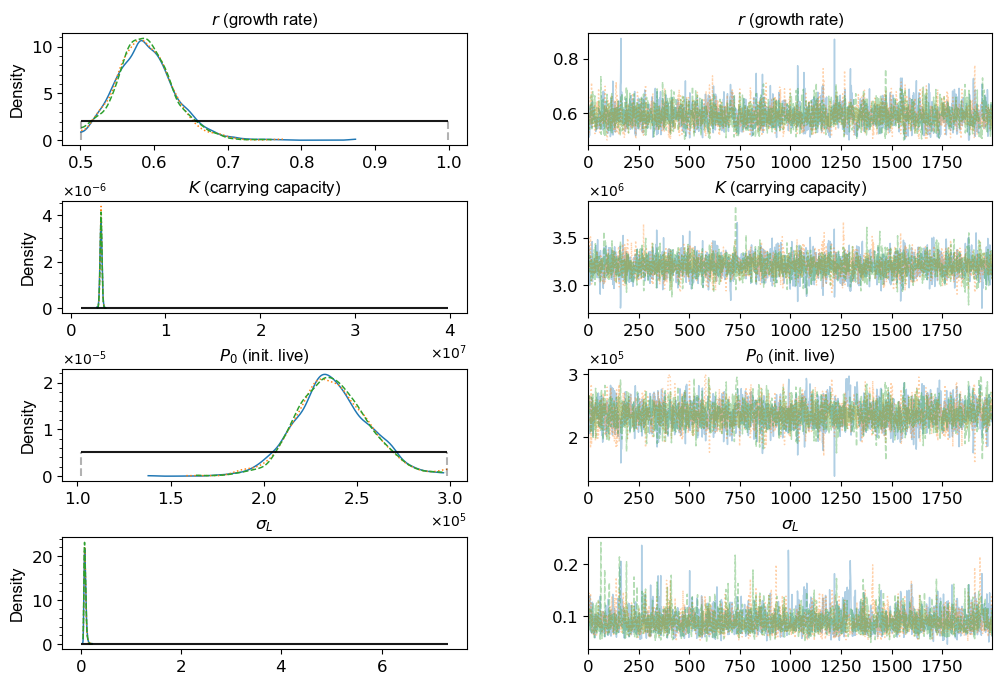

array([[<Axes: title={'center': '$r$ (growth rate)'}, ylabel='Density'>,
        <Axes: title={'center': '$r$ (growth rate)'}>],
       [<Axes: title={'center': '$K$ (carrying capacity)'}, ylabel='Density'>,
        <Axes: title={'center': '$K$ (carrying capacity)'}>],
       [<Axes: title={'center': '$P_0$ (init. live)'}, ylabel='Density'>,
        <Axes: title={'center': '$P_0$ (init. live)'}>],
       [<Axes: title={'center': '$\\sigma_L$'}, ylabel='Density'>,
        <Axes: title={'center': '$\\sigma_L$'}>]], dtype=object)

In [7]:
plot_trace(
trace=trace,
model=model,
fontname='Arial',
fontsize=12,
num_prior_samples=200,
save_path='figures/vardi_logistic_growth_chains.png'
)

Now we interpret the results. Remember the ODE's from before.

$$
\frac{dP}{dt} = r \left(1 - \frac{P}{K}\right) P
$$

Take note of x-axis values at the peaks of the PDFs and the variables they represent. The x-axis values at those peaks are what the model found to be the optimal value for the equation. The right hand column is a frequency plot. This is just to make sure the model is exploring the parameter space well enough. 


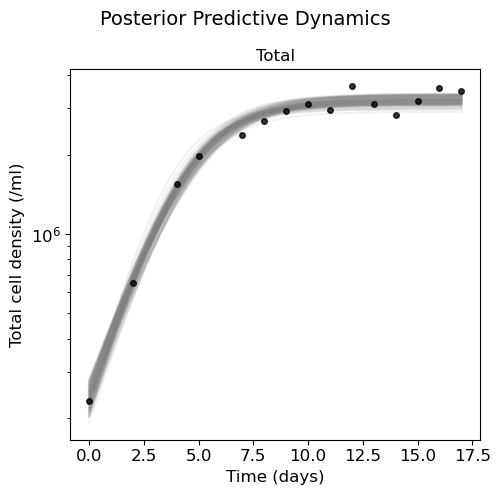

(<Figure size 500x500 with 1 Axes>,
 [<Axes: title={'center': 'Total'}, xlabel='Time (days)', ylabel='Total cell density (/ml)'>])

In [8]:
dataset_postprocessing = {
"Total cells": [
        {"time": cells_time, "values":  cells_density},  # replicate 1
    ]
}

def ode_solution2data(solution):
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }

posterior_dynamics(
dataset=dataset_postprocessing,
trace=trace,
model=model,
n_plots=100,
burn_in=50,
num_variables=1,
ode_fn=logistic_growth,
ode2data_fn=ode_solution2data,
save_path="figures/vardi_logistic_growth_dynamics.png",
var_properties={
    "Total cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)","sol_key": "total","log": True}
},
suptitle="Posterior Predictive Dynamics"
)

This plot is showing how well the range of estimated chains fit the observed data. 

**CONGRATULATIONS!** you just ran you first MCMC!

## Case Study 2: Logistic Growth and Death

Now on to a more complex model. We will be using the same data as before as well as some data on dead cells. We will also being using two ODEs!

In [9]:
## Cell 6 ##

import pandas as pd

# import alive
dataset = pd.read_csv("../../case_study_2/python/data/total_cells.csv")
cells = dataset.tail(15)
cells_time = cells['Time (days)'].values
cells_density = 1e6*cells[' Density (1e6/ml)'].values

# import dead
death_dataset = pd.read_csv("../../case_study_2/python/data/death_percentage.csv")
death = death_dataset.tail(15)
dead_time = death['Time (days)'].values
dead_density = death[' Dead percentage '].values*cells_density/100


**ODE for living cells accounting for cell death**

$$
\frac{dP}{dt} = r \left(1 - \frac{P}{K}\right) P - \delta P
$$

**ODE for dead cells**

$$
\frac{dD}{dt} = \delta P
$$

We follow the same rules as before when creating this ODE. The new part of this is how we return the equation to PYMC. Note that in our previous ODE we returned an equation of lists to to PyMC that looked like

[] = [] * (1 = [] / []) * []

Since PyMC expects a matrix as a return value, it was able to accept the 1-D column right there since that is still a matrix. 

We take advantage of this when we have multiple equations. All you have to do is expand the matrix.

x[[],[]]  
x[0] = [] * (1 = [] / []) * [] - [] * []  
x[1] = [] * []

In [10]:
## Cell 7 ##


def logistic_growth_death(y, t, params):
    P = y[0]
    r = params[0]
    K = params[1]
    delta = params[2]

    dydt = []
    dydt.append(r * (1 - P / K) * P - delta * P)
    dydt.append(delta * P)
    return dydt

Here we have our new model setup. We have 3 unique parameters (r, K, delta) so we'll set **n_theta** to 3. **n_states** will now be 2 since we now have two ODE's we are tracking two states (alive, dead). 

**note**: We will end up with 5 priors for the 5 variables just mentioned. Plus two more for sigma_live and sigma_dead. Totaling 7.

In [11]:
## Cell 8 ##
import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=logistic_growth_death,
    times=cells_time,
    n_states=2,
    n_theta=3, 
    t0=0
)

This portion is new! When in doubt always create helper functions. They improve readability and modularity of your code. In practice it also helps debugging. 

Now that we have more information in our output, it will help to have a function break it down for us to make calling it easier later on. Here we just split the y_hat output into live and dead. Remember that the live in our model is at position 0 and dead is at 1. Additionally we want total and dead, not live and dead so we do a little addition and we're done. You can do whatever you want to here to help make the next block run cleaner.

In [12]:
## Cell 9 ##

def ode_solution2data(solution):
    live = solution[:, 0]
    dead = solution[:, 1]
    total = live + dead
    return {
        "total": total,
        "dead": dead
    }

Here is the model. Everything here should make sense. If something is confusing see the explination above cell 4. Still note that we have two likelihoods at the bottom since we are estimating two states. 

In [13]:
## Cell 10 ##
import numpy as np
with pm.Model() as model:
    r = pm.Uniform(r"$r$ (growth rate)", lower=0.5, upper=1)
    K = pm.Uniform(r"$K$ (carrying capacity)" , lower=1e6, upper=4e7)
    delta = pm.Uniform(r"$\delta$ (death rate)", lower=0.0, upper=0.15)
    P0 = pm.Uniform(r"$P_0$ (init. live)", lower=1e5, upper=3e5)
    D0 = pm.Uniform(r"$D_0$ (init. dead)", lower=1e4, upper=7e4)

    sigma_live = pm.HalfNormal(r"$\sigma_L$", 3)
    sigma_dead = pm.HalfNormal(r"$\sigma_D$", 3)

    y_hat = cell_model(y0=[P0,D0], theta=[r,K,delta])
    y_hat_sol = ode_solution2data(y_hat)
    total_solution = y_hat_sol['total']
    dead_solution = y_hat_sol['dead']

    pm.Normal("Y_live", mu=pm.math.log(pm.math.clip(total_solution, 1e-8, np.inf)),sigma=sigma_live,
            observed =  np.log(cells_density))

    pm.Normal("Y_dead", mu=pm.math.log(pm.math.clip(dead_solution, 1e-8, np.inf)),sigma=sigma_dead,
            observed=np.log(dead_density))

Everything here is that same as before! See the explination above cell 5 if you forgot something.

In [14]:
## Cell 11 ##
'''
with model:
    trace = pm.sample(draws=1000, tune=500, chains=3, return_inferencedata=True, target_accept=0.95, cores = 3) 
'''
import arviz as az
trace = az.from_netcdf("chains/case_study_2_p2_trace.nc")

Sampling: [$D_0$ (init. dead), $K$ (carrying capacity), $P_0$ (init. live), $\delta$ (death rate), $\sigma_D$, $\sigma_L$, $r$ (growth rate), Y_dead, Y_live]


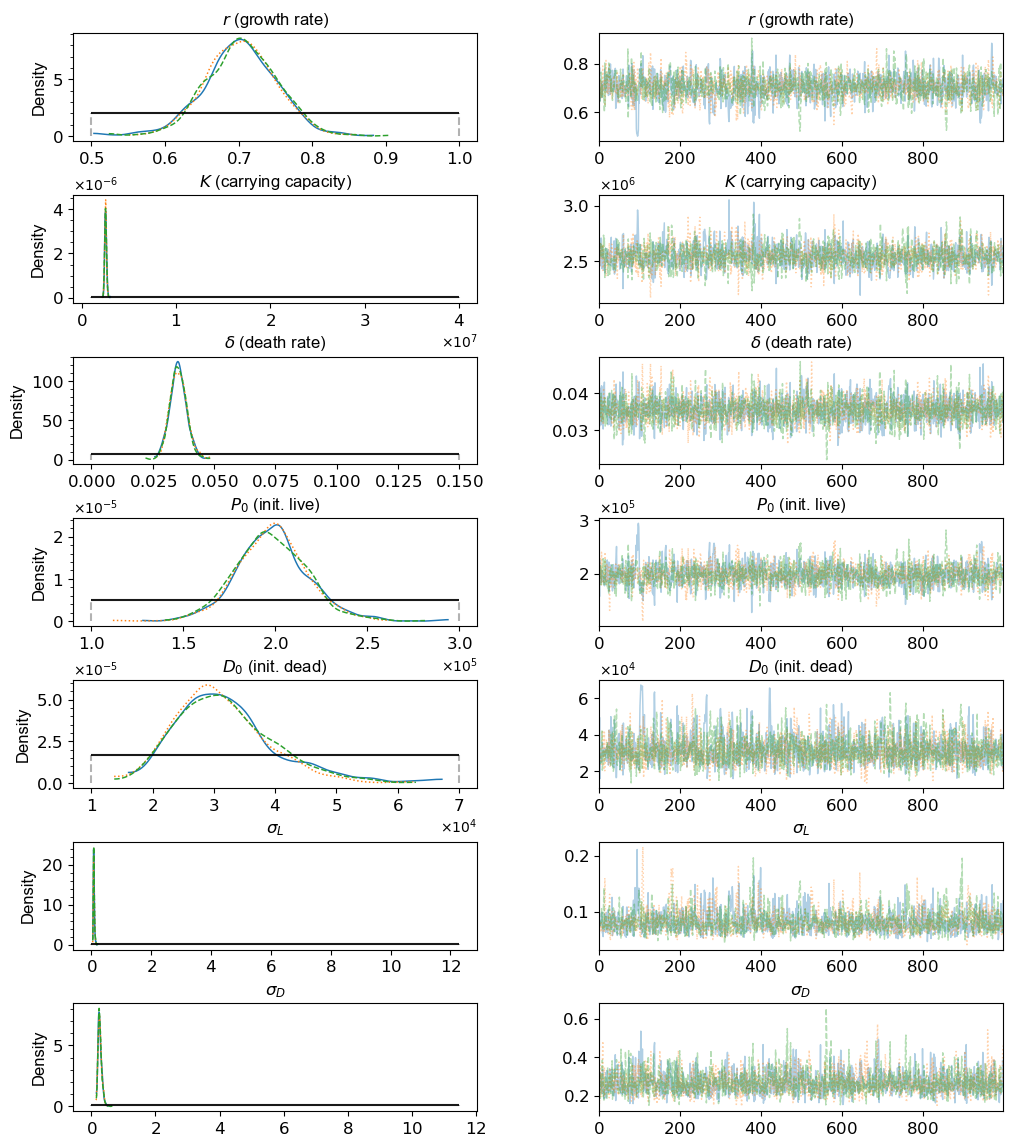

array([[<Axes: title={'center': '$r$ (growth rate)'}, ylabel='Density'>,
        <Axes: title={'center': '$r$ (growth rate)'}>],
       [<Axes: title={'center': '$K$ (carrying capacity)'}, ylabel='Density'>,
        <Axes: title={'center': '$K$ (carrying capacity)'}>],
       [<Axes: title={'center': '$\\delta$ (death rate)'}, ylabel='Density'>,
        <Axes: title={'center': '$\\delta$ (death rate)'}>],
       [<Axes: title={'center': '$P_0$ (init. live)'}, ylabel='Density'>,
        <Axes: title={'center': '$P_0$ (init. live)'}>],
       [<Axes: title={'center': '$D_0$ (init. dead)'}, ylabel='Density'>,
        <Axes: title={'center': '$D_0$ (init. dead)'}>],
       [<Axes: title={'center': '$\\sigma_L$'}, ylabel='Density'>,
        <Axes: title={'center': '$\\sigma_L$'}>],
       [<Axes: title={'center': '$\\sigma_D$'}, ylabel='Density'>,
        <Axes: title={'center': '$\\sigma_D$'}>]], dtype=object)

In [15]:
plot_trace(
trace=trace,
model=model,
fontname='Arial',
fontsize=12,
num_prior_samples=2000,
save_path='figures/vardi_growth_death_chains.png'
)


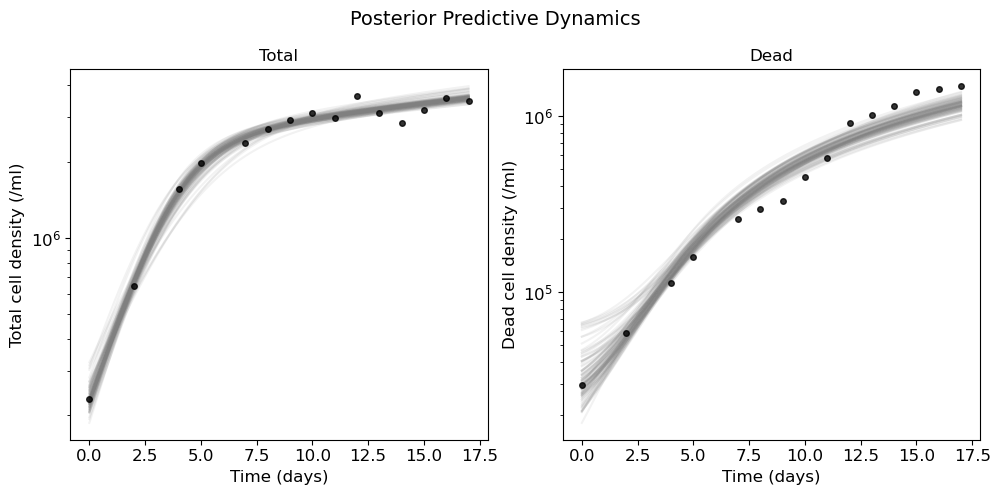

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Total'}, xlabel='Time (days)', ylabel='Total cell density (/ml)'>,
        <Axes: title={'center': 'Dead'}, xlabel='Time (days)', ylabel='Dead cell density (/ml)'>],
       dtype=object))

In [16]:
dataset_postprocessing = {
"Total cells": [
        {"time": cells_time, "values":  cells_density},  # replicate 1
    ],
"Dead cells": [
        {"time": dead_time, "values": dead_density},  # replicate 1
    ]
}

def ode_solution2data(solution):
    live = solution[:, 0]
    dead = solution[:, 1]
    total = live + dead
    return {
        "total": total,
        "dead": dead
    }

posterior_dynamics(
dataset=dataset_postprocessing,
trace=trace,
model=model,
n_plots=100,
burn_in=50,
num_variables=2,
ode_fn=logistic_growth_death,
ode2data_fn=ode_solution2data,
save_path="figures/vardi_growth_death_dynamics.png",
var_properties={
    "Total cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)", "sol_key": "total","log": True},
    "Dead cells": {"label": "Dead", "color": "black", "ylabel": "Dead cell density (/ml)", "xlabel":"Time (days)", "sol_key": "dead","log": True},
},
suptitle="Posterior Predictive Dynamics"
)

## THE END